<a href="https://colab.research.google.com/github/YusukeAoki57/diveintocode-ml/blob/master/sprint_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = X_train.reshape(-1, 1,784)
X_test = X_test.reshape(-1, 1,784)

In [4]:

x_train = X_train.astype(np.float)
x_test = X_test.astype(np.float)
x_train /= 255
x_test /= 255
print(x_train.max())  # 1.0
print(x_train.min())  # 0.0

1.0
0.0


In [5]:
def split_data(data, permutation, val_size_rate=0.2):
    data = data[permutation]
    val_size = int(len(data) * val_size_rate)
    val = data[:val_size]
    train = data[val_size:]
    return train, val

permutation = np.random.permutation(np.arange(len(x_train)))
x_train, x_val = split_data(x_train, permutation)
y_train, y_val = split_data(y_train, permutation)
print(x_train.shape)  # (48000, 784)
print(y_train.shape)  # (12000, 784)

(48000, 1, 784)
(48000,)


In [6]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [7]:
class SimpleConv1d:
  def __init__(self,optimizer,filter_size=3,stride=1,pading=0):
    self.optimizer = optimizer
    self.filter_size=filter_size
    self.W = np.array([3, 5, 7])
    self.B = np.array([1])
    #self.W = initializer.W(self.filter_size1)
    #self.B = initializer.B(self.filter_size1)
    self.stride=stride
    self.pading=pading
    self.dW=np.zeros((self.filter_size))

  def forward(self, X):
    self.X = X
    a_size=self._n_out(self.X)
    self.a=np.zeros((a_size))
    for i in range(a_size):
      for s in range(self.filter_size):
        if s==self.filter_size-1:
          i=i+self.stride-1 #stride反映
        self.a[i] =self.a[i]+self.X[i+s]*self.W[s]
      self.a[i] =self.a[i]+self.B
      print(self.a[i])
    return self.a

  def backward(self, dA,X):
    """
    バックワード
    Parameters
    ----------
    dA : 次の形のndarray, shape (batch_size, n_nodes2)
        後ろから流れてきた勾配
    Returns
    ----------
    dZ : 次の形のndarray, shape (batch_size, n_nodes1)
        前に流す勾配
    """
    self.X=X
    n=self._n_out(self.X)
    for s in range(self.filter_size): #outputsizeに要変更
      for i in range(n):
        if s==self.filter_size-1:
          i=i+self.stride-1 #stride反映
        self.dW[s] =self.dW[s]+dA[i]*self.X[i+s] #(1,3)
    self.dB =np.sum(dA,axis=0)
    """
    self.dX=np.zeros
    for j in range(self.X.shape[0]):
      for s in range(self.filter_size-1):
        if (j-s)<0 or (j-s)>n:
          dA=0 
        self.dX=+ dA[j-s]*self.W[s]

    self.optimizer.update(self)
    return dX
    """
    return self.dW,self.dB

  def _n_out(self,X):
    self.X=X
    n_o=(self.X.shape[0]+2*self.pading-self.filter_size)/self.stride+1
    return int(n_o)

In [8]:
#問題3 forward
x = np.array([1,2,3,4])
sc=SimpleConv1d(optimizer='SGD')
a=sc.forward(x)
a

35.0
50.0


array([35., 50.])

In [9]:
#問題3 backward
delta_a = np.array([10, 20])
dw,db=sc.backward(delta_a,x)
print(dw)
print(db)

[ 50.  80. 110.]
30


In [10]:
#問4
class Conv1d:
  def __init__(self,optimizer,filter_size=3,stride=1,pading=0):
    self.optimizer = optimizer
    self.filter_size=filter_size
    self.W = np.ones((3, 2, 3)) # 例の簡略化のため全て1とする。(出力チャンネル数、入力チャンネル数、フィルタサイズ)である。
    self.B = np.array([1, 2, 3]) # （出力チャンネル数）
    #self.W = initializer.W(self.filter_size1)
    #self.B = initializer.B(self.filter_size1)
    self.stride=stride
    self.pading=pading
    self.dW=np.zeros((self.filter_size))

  def forward(self, X):
    self.X = X
    n=self._n_out(self.X)
    self.a=np.zeros((self.W.shape[0],n))
    for z in range(self.W.shape[0]):
      for k in range(self.X.shape[0]):
        for i in range(n):
          for s in range(self.filter_size):
            if s==self.filter_size-1:
              i=i+self.stride-1 #stride反映
            self.a[z][i] =self.a[z][i]+self.X[k,i+s]*self.W[z,k,s]
      self.a[z,:] =self.a[z,:]+self.B[z]
    return self.a

  def backward(self, dA,X):
    """
    バックワード
    Parameters
    ----------
    dA : 次の形のndarray, shape (batch_size, n_nodes2)
        後ろから流れてきた勾配
    Returns
    ----------
    dZ : 次の形のndarray, shape (batch_size, n_nodes1)
        前に流す勾配
    """
    self.X=X
    n=self._n_out(self.X)
    for s in range(self.filter_size): #outputsizeに要変更
      for i in range(n):
        if s==self.filter_size-1:
          i=i+self.stride-1 #stride反映
        self.dW[s] =self.dW[s]+dA[i]*self.X[i+s] #(1,3)
    self.dB =np.sum(dA,axis=0)
    """
    self.dX=np.zeros
    for j in range(self.X.shape[0]):
      for s in range(self.filter_size-1):
        if (j-s)<0 or (j-s)>n:
          dA=0 
        self.dX=+ dA[j-s]*self.W[s]

    self.optimizer.update(self)
    return dX
    """
    return self.dW,self.dB

  def _n_out(self,X):
    self.X=X
    n_o=(self.X.shape[1]+2*self.pading-self.filter_size)/self.stride+1
    return int(n_o)

In [11]:
#問題4
x = np.array([[1, 2, 3, 4], [2, 3, 4, 5]]) 
c1=Conv1d(optimizer='SGD')
a=c1.forward(x)
print(a)

[[16. 22.]
 [17. 23.]
 [18. 24.]]


In [12]:
#問題8
class ScratchDeepNeuralNetrowkClassifier:
    def __init__(self, batch_size = 20,init='Sinmple',ac='Tanh',opt='SGD', seed=0):
        self.batch_size=batch_size
        self.n_features=784
        self.n_nodes1=400
        self.n_nodes2=200
        self.n_output=10
        self.sigma=0.01
        self.init=init
        self.ac=ac
        self.opt=opt
        self.W1=None
        self.W2=None
        self.W3=None
        self.B1=None
        self.B2=None
        self.B3=None
        self.fanction=None
        self.optimizer=None
        self.filter_size=3
        self.pading=0
        self.stride=1
        self.n_o=None

    def _n_out(self,X):
      self.n_o=(X.shape[2]+2*self.pading-self.filter_size)/self.stride+1
      self.n_o=int(self.n_o)
      return self.n_o
    def _initializer(self,X):
      if self.init=='Sinmple':
        self.n_nodes1=self._n_out(X)
        self.W1 = self.sigma * np.random.randn(self.filter_size)    
        self.W2=SimpleInitializer(self.sigma).W(self.n_nodes1,self.n_nodes2)
        self.W3=SimpleInitializer(self.sigma).W(self.n_nodes2,self.n_output)
        self.B1=self.sigma * np.random.randn(1,)
        self.B2=SimpleInitializer(self.sigma).B(self.n_nodes2)
        self.B3=SimpleInitializer(self.sigma).B(self.n_output)
        
      elif self.init=='Xavier':
        self.n_nodes1=self._n_out(X)
        self.sigma = math.sqrt(1 / self.filter_size)
        self.W1 = self.sigma * np.random.randn(self.filter_size)
        self.W2=He().W(self.n_nodes1,self.n_nodes2)
        self.W3=He().W(self.n_nodes2,self.n_output)
        self.sigma = math.sqrt(1 / self.filter_size)
        self.B1 = self.sigma * np.random.randn(1)
        self.B2=He().B(self.n_nodes1,self.n_nodes2)
        self.B3=He().B(self.n_nodes2,self.n_output)
      
      elif self.init=='He':
        self.n_nodes1=self._n_out(X)
        self.sigma = math.sqrt(2 / self.filter_size)
        self.W1 = self.sigma * np.random.randn(self.filter_size)
        self.W2=He().W(self.filter_size)
        self.W3=He().W(self.filter_size)
        self.sigma = math.sqrt(2 / self.filter_size)
        self.B1 = self.sigma * np.random.randn(1)
        self.B2=He().B(1)
        self.B3=He().B(1)


    def fit(self, X,y):
        
        if self.ac=='Tanh':
          self.fanction=Tanh()
        elif self.ac=='ReLU':
          self.fanction=ReLU()
        else:
          self.fanction=Sigmoid()

        if self.opt=='SGD':
          self.optimizer=SGD()
        else:
          self.optimizer=AdaGrad()


        n_epochs = 5
        #n_step_iteration_report = 384
        plot_data = []
        Loss=[]
        Val_loss=[]
        Epoch=[]
        self.X=X
        self.y=y
        new_loss=[]       
        #y_val = y_val.reshape(-1, 1) == np.arange(10)
        self._initializer(X)
        self.n_o=self._n_out(X)
        for epoch in range(n_epochs):
            for i, (x, y) in enumerate(GetMiniBatch(self.X,self.y,self.batch_size)):
            #forword
              y = y.reshape(-1, 1) == np.arange(10)
              y=y.reshape(y.shape[0],10)
              self.Conv1,self.n_nodes1 = Conv(self.W1,self.B1,self.optimizer,self.n_o).forward(x) #(1,782)
              self.activation1 = self.fanction.forward(self.Conv1)

              self.FC2 = FC(self.W2,self.B2,self.optimizer).forward(self.activation1) #(20,200)
              self.activation2 = self.fanction.forward(self.FC2) 
              #print("a2"+str(self.activation2.shape))
              self.FC3 = FC(self.W3,self.B3,self.optimizer).forward(self.activation2) #(1,10)
              self.activation3 = Softmax(self.batch_size).forward(self.FC3) 
              self.loss=Softmax(self.batch_size).loss(self.activation3,y) 
              #backword
              self.dloss=Softmax(self.batch_size).backward(self.activation3,y) #(20,10)
              
              self.W3,self.B3,self.dZ2 = FC(self.W3,self.B3,self.optimizer).backward(self.dloss,self.activation2) #(20,10)*(20,200)=()
              self.dactivation2 = self.fanction.backward(self.dZ2, self.activation2)
              self.W2,self.B2,self.dZ1 = FC(self.W2,self.B2,self.optimizer).backward(self.dactivation2,self.activation1) #(1,200)
              self.dactivation1 = self.fanction.backward(self.dZ1,self.activation1)
              self.W1,self.B1,self.dX = Conv(self.W1,self.B1,self.optimizer,self.n_o).backward(x,self.dactivation1) #(784,400) 
              Loss.append(self.loss)
              
            new_loss.append(np.mean(Loss))
            Loss=[] 
            print(new_loss)
            Epoch.append(epoch)
        plt.plot(Epoch, new_loss, color='r', label='train_loss')
        #plt.plot(Epoch, Val_loss, color='b', label='val_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.show()
      
    def predict(self,x):
        self.Conv1,self.n_nodes1 = Conv(self.W1,self.B1,self.optimizer,self.n_o).forward(x) #(20,782)
        self.activation1 = self.fanction.forward(self.Conv1)
        self.FC2 = FC(self.W2,self.B2,self.optimizer).forward(self.activation1) #(20,200)
        self.activation2 = self.fanction.forward(self.FC2) 
        #print("a2"+str(self.activation2.shape))
        self.FC3 = FC(self.W3,self.B3,self.optimizer).forward(self.activation2) #(1,10)
        self.activation3 = Softmax(self.batch_size).forward(self.FC3) 
        result=self.activation3.argmax(axis=1)
        return result


In [13]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self,W,B,optimizer,batch_size=20):
        #重みの初期化
        self.W=W
        self.B=B
        self.optimizer=optimizer
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        
        A=np.dot(X,self.W)+self.B 
        #(20,782)*(782,200)=(20,200)
        #(20,200)*(200,10)=(20,10)
        return A
    def backward(self,X,dactivation):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB=np.sum(X,axis=0) 
        dW=np.dot(dactivation.T,X) #(10,20)*(20,200)=(10,200)
        dZ=np.dot(X,self.W.T) 
        self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)
        return self.W,self.B,dZ

    def backward2(self,X,dactivation):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB=np.sum(dactivation,axis=0) 
        dW=np.dot(X.T,dactivation) #(784,20)*(20,400)=(784,400)
        #print(dW.shape)
        self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)
        return self.W,self.B


In [14]:
class Conv:
  def __init__(self,W,B,optimizer,n,filter_size=3,stride=1,pading=0):
    self.optimizer = optimizer
    self.filter_size=filter_size
    self.W = W
    self.B = B
    self.stride=stride
    self.pading=pading
    self.n=n

  def forward(self, X):
    self.a=np.zeros((X.shape[0],self.n))
    for k in range(X.shape[0]):
      for i in range(self.n):
        for s in range(self.filter_size):
          if s==self.filter_size-1:
            i=i+self.stride-1 #stride反映
          self.a[k][i] =self.a[k][i]+X[k,0,i+s]*self.W[s]
        self.a[k][i] =self.a[k][i]+self.B[0]
        a_shape=self.a.shape[1]
        #print("a:"+str(self.a.shape))
      return self.a,a_shape

  def backward(self, X,dA):
    """
    バックワード
    Parameters
    ----------
    dA : 次の形のndarray, shape (batch_size, n_nodes2)
        後ろから流れてきた勾配
    Returns
    ----------
    dZ : 次の形のndarray, shape (batch_size, n_nodes1)
        前に流す勾配
    """
    dW=np.zeros((self.filter_size))
    for k in range(X.shape[0]):
      for s in range(self.filter_size): #outputsizeに要変更
        for i in range(self.n):
          if s==self.filter_size-1:
            i=i+self.stride-1 #stride反映
          d=dA[0,i]*X[k,0,i+s]
          dW[s] =dW[s]+d #(1,3)
    dB =np.sum(dA,axis=0)
    
    dX=np.zeros((self.n))
    for j in range(self.n):
      for s in range(self.filter_size):
        if (j-s)<0 or (j-s)>self.n:
          dA[0,j-s]=0
        dX[j] =dX[j]+dA[0,j-s]*self.W[s]
      

    self.W,self.B=self.optimizer.update(self.W,self.B,dW,dB)

    return self.W,self.B,dX


In [15]:
class Tanh:
      def forward(self,X):
        Z=np.tanh(X)
        return Z
      def backward(self,X,activation):
        dA=X*(1-activation**2)
        return dA

In [16]:
class Softmax:
      def __init__(self,batch_size=20):
        self.batch_size=batch_size
      def forward(self,X):
        log_z3 = np.log(np.exp(X)) - self._logsumexp(X) #(20,10)
        self.Z3 = np.exp(log_z3) #(20,10)
        return self.Z3
      def _logsumexp(self,X):
        xmax = np.max(X,axis=1)
        xmax=xmax.reshape(X.shape[0],1)
        return np.log(np.exp(X - xmax).sum(axis=1, keepdims=True)) + xmax
      def loss(self,X,y):
        L=-np.sum(np.sum(y*np.log(X),axis=1),axis=0)/self.batch_size 
        return L
      def backward(self,L,y):
        dA3=(L-y)/self.batch_size #(20,10)
        return dA3

In [17]:
class SimpleInitializer:
      def __init__(self, sigma=0.01):
        self.sigma = sigma
      def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        
        self.W = self.sigma * np.random.randn(n_nodes1,n_nodes2)    
        return self.W
      def B(self, n_nodes):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        #バイアス項の初期値
        sigm=0.01
        self.B=self.sigma * np.random.randn(n_nodes,)
        return self.B


In [18]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self,W,B,dW,dB):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        W=W-self.lr*dW
        B=B-self.lr*dB

        return W,B
        
        

In [19]:
class ReLU:
   def forward(self,A):
     return np.clip(A, 0, None)
    
   def backward(self,dZ, A):
     return dZ * np.clip(np.sign(A), 0, None)

In [20]:
import math
class XavierInitializer:
  def W(self, n_nodes1, n_nodes2):
      self.sigma = math.sqrt(1 / n_nodes1)
      W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
      return W
  def B(self, n_nodes1,n_nodes2):
      self.sigma = math.sqrt(1 / n_nodes1)
      B = self.sigma * np.random.randn(n_nodes2)
      return B

In [21]:
import math
class He:
  def W(self, n_nodes1, n_nodes2):
      self.sigma = math.sqrt(2 / n_nodes1)
      W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
      return W
  def B(self, n_nodes1,n_nodes2):
      self.sigma = math.sqrt(2 / n_nodes1)
      B = self.sigma * np.random.randn(n_nodes2)
      return B

In [22]:
class AdaGrad:
    
    def __init__(self, lr=0.01):
        self.lr = lr
        self.HW = 1
        self.HB = 1
    
    def update(self,W,B,dW,dB):
        self.HW += dW**2
        self.HB += dB**2
        W -= self.lr * np.sqrt(1/self.HW) * dW
        B -= self.lr * np.sqrt(1/self.HB) * dB
        self.HW=1
        self.HB=1
        return W,B

In [23]:
class Sigmoid:
    
    def forward(self, A):
        self.A = A
        return self.sigmoid(A)
    
    def backward(self, dZ, A):
        self.A=A
        _sig = self.sigmoid(self.A)
        return dZ * (1 - _sig)*_sig
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))

[2.2666437953379726]
[2.2666437953379726, 2.2320021830569683]
[2.2666437953379726, 2.2320021830569683, 2.2212011011126136]
[2.2666437953379726, 2.2320021830569683, 2.2212011011126136, 2.216060059795475]
[2.2666437953379726, 2.2320021830569683, 2.2212011011126136, 2.216060059795475, 2.212980453225706]


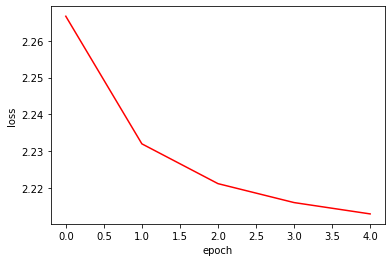

In [24]:
#問題8
sdnn=ScratchDeepNeuralNetrowkClassifier(init='Xavier')
sdnn.fit(x_train,y_train)

In [25]:
y_pred=sdnn.predict(X_test)
y_pred

array([7, 1, 1, ..., 1, 1, 1])

In [26]:
#Accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.1136
